# Türkiye Deprem Analizi ve Risk Tahmin Sistemi

Bu notebook, Türkiye deprem verilerini **canlı API** üzerinden günceller ve analiz eder.

- **Kısa vadeli risk (30 gün, M≥4):** CatBoost + zaman serisi bölme (TimeSeriesSplit)
- **Uzun vadeli tehlike (10 yıl, M≥6):** İstatistiksel yaklaşım (Poisson temelli)
- **Jeolojik bileşen:** Fay hattına mesafeye göre segment riski
- **Demo:** Colab üzerinden şehir girerek risk skoru üretme

> Not: Çalışma eğitim amaçlıdır; kesin deprem tahmini değildir.


## 1) Kurulum ve Ortam Ayarları

Bu bölümde veri analizi, görselleştirme ve makine öğrenmesi için
kullanılacak kütüphaneler yüklenir.

Grafiklerin daha okunabilir olması için stil ayarları yapılır
ve uyarı mesajları kapatılır.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, math, requests
from datetime import datetime, timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             roc_curve, auc)

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✓ Kütüphaneler yüklendi.")


✓ Kütüphaneler yüklendi.


## 2) Kontrol Paneli

Notebook’un farklı bölümleri bu panel üzerinden kontrol edilir.

Amaç:
- Sunum sırasında bazı bölümleri kapatabilmek
- Deneme sırasında tüm sistemi çalıştırabilmek
- Tek noktadan yönetim sağlamak


In [25]:
CSV_FILE_PATH = "/content/query.csv"
API_URL = "https://api.orhanaydogdu.com.tr/deprem/kandilli/live"

RUN_API_UPDATE = True
RUN_TURKEY_MAP = True
RUN_CATBOOST = True
RUN_RISK_APP = True

SELECTED_CITIES = ["İstanbul", "İzmir", "Ankara", "Hatay", "Elazığ", "Van"]

print("✓ Kontrol paneli hazır.")


✓ Kontrol paneli hazır.


## 3) Türkiye Şehir Koordinatları

Bu bölümde Türkiye’deki şehir merkezlerinin yaklaşık
enlem ve boylam değerleri tanımlanır.

Bu bilgiler:
- Şehir merkezine olan mesafe hesaplamasında
- Bölgesel deprem analizlerinde
kullanılacaktır.


In [26]:
city_coords_dict = {
    "Adana": (37.0, 35.3213),
    "Adıyaman": (37.7648, 38.2786),
    "Afyonkarahisar": (38.7638, 30.5402),
    "Ağrı": (39.7191, 43.0511),
    "Aksaray": (38.3687, 34.0369),
    "Amasya": (40.6521, 35.8353),
    "Ankara": (39.9334, 32.8597),
    "Antalya": (36.8969, 30.7133),
    "Artvin": (41.1820, 41.8181),
    "Aydın": (37.8445, 27.8457),
    "Balıkesir": (39.6494, 27.8826),
    "Bilecik": (40.1500, 29.9833),
    "Bingöl": (38.8841, 40.4939),
    "Bitlis": (38.4000, 42.1167),
    "Bolu": (40.5760, 31.5789),
    "Burdur": (37.7200, 30.2900),
    "Bursa": (40.195, 29.060),
    "Çanakkale": (40.1553, 26.4142),
    "Çankırı": (40.6013, 33.6133),
    "Çorum": (40.5481, 34.9530),
    "Denizli": (37.7765, 29.0864),
    "Diyarbakır": (37.9144, 40.2306),
    "Edirne": (41.6771, 26.5556),
    "Elazığ": (38.6781, 39.2231),
    "Erzincan": (39.7500, 39.5000),
    "Erzurum": (39.9000, 41.2700),
    "Eskişehir": (39.7767, 30.5206),
    "Gaziantep": (37.0625, 37.3794),
    "Giresun": (40.9128, 38.3895),
    "Gümüşhane": (40.4600, 39.4850),
    "Hakkari": (37.5747, 43.7402),
    "Hatay": (36.2028, 36.1600),
    "Isparta": (37.7648, 30.5566),
    "İstanbul": (41.0082, 28.9784),
    "İzmir": (38.4192, 27.1287),
    "Kahramanmaraş": (37.5761, 36.9371),
    "Karabük": (41.2000, 32.6200),
    "Karaman": (37.1814, 33.2150),
    "Kars": (40.6013, 43.0975),
    "Kastamonu": (41.3887, 33.7827),
    "Kayseri": (38.7322, 35.4853),
    "Kırıkkale": (39.8467, 33.5150),
    "Kırklareli": (41.7333, 27.2167),
    "Kırşehir": (39.1453, 34.1630),
    "Kilis": (36.7167, 37.1167),
    "Kocaeli": (40.7667, 29.9167),
    "Konya": (37.8713, 32.4841),
    "Kütahya": (39.4167, 29.9833),
    "Malatya": (38.3556, 38.3097),
    "Manisa": (38.6191, 27.4289),
    "Mardin": (37.3121, 40.7350),
    "Mersin": (36.7999, 34.6050),
    "Muğla": (37.2150, 28.3636),
    "Muş": (38.9461, 41.7531),
    "Nevşehir": (38.6244, 34.7140),
    "Niğde": (37.9667, 34.6833),
    "Ordu": (40.9833, 37.8833),
    "Osmaniye": (37.0742, 36.2383),
    "Rize": (41.0200, 40.5210),
    "Sakarya": (40.7776, 30.3470),
    "Samsun": (41.2867, 36.33),
    "Siirt": (37.9333, 41.9500),
    "Sinop": (42.0231, 35.1533),
    "Sivas": (39.7477, 37.0170),
    "Şanlıurfa": (37.1674, 38.7951),
    "Şırnak": (37.4186, 42.4915),
    "Tekirdağ": (40.9780, 27.5117),
    "Tokat": (40.3119, 36.5540),
    "Trabzon": (41.0027, 39.7160),
    "Tunceli": (39.1083, 39.5592),
    "Uşak": (38.6749, 29.3987),
    "Van": (38.5010, 43.4160),
    "Yalova": (40.6500, 29.2667),
    "Yozgat": (39.8172, 34.8147),
    "Zonguldak": (41.4564, 31.7987)
}

print(f"✓ {len(city_coords_dict)} şehir koordinatı yüklendi.")


✓ 75 şehir koordinatı yüklendi.


## 4) Canlı Deprem Verisi Güncelleme (Kandilli API)

Bu bölümde Kandilli Rasathanesi’nin sunduğu canlı API kullanılarak
yeni deprem kayıtları kontrol edilir.

Yeni bulunan kayıtlar otomatik olarak CSV dosyasına eklenir.
Bu sayede analiz her çalıştırıldığında güncel veriyle yapılır.


In [27]:
def fetch_and_update_data(csv_path):
    print("🌍 Kandilli API kontrol ediliyor...")

    try:
        # 1) Mevcut CSV varsa oku ve son zamanı UTC (tz-aware) yap
        if os.path.exists(csv_path):
            df_existing = pd.read_csv(csv_path)

            # time parse
            df_existing["time"] = pd.to_datetime(df_existing["time"], errors="coerce")

            # Eğer tz yoksa UTC varsay; varsa UTC'ye çevir
            if df_existing["time"].dt.tz is None:
                df_existing["time"] = df_existing["time"].dt.tz_localize("UTC")
            else:
                df_existing["time"] = df_existing["time"].dt.tz_convert("UTC")

            last_time = df_existing["time"].max() if not df_existing.empty else pd.Timestamp.min.tz_localize("UTC")
        else:
            df_existing = pd.DataFrame()
            last_time = pd.Timestamp.min.tz_localize("UTC")

        print(f"📅 Son kayıtlı deprem tarihi (UTC): {last_time}")

        # 2) API'den çek
        response = requests.get(API_URL, timeout=10)
        if response.status_code != 200:
            print(f"❌ API bağlantı hatası: {response.status_code}")
            return

        data = response.json()
        if not data.get("status"):
            print("❌ API veri döndürmedi")
            return

        new_records = []

        for eq in data["result"]:
            date_str = eq.get("date_time")
            if not date_str:
                continue

            # Kandilli "date_time" genelde TR saati gibi geliyor.
            # Biz bunu Europe/Istanbul kabul edip UTC'ye çeviriyoruz.
            try:
                t = pd.to_datetime(date_str.replace(".", "-"), errors="raise")
                t = t.tz_localize("Europe/Istanbul").tz_convert("UTC")
            except Exception:
                continue

            # 3) Karşılaştırma artık tz-aware UTC ile güvenli
            if t > last_time:
                coords = eq.get("geojson", {}).get("coordinates", [None, None])
                new_records.append({
                    "time": t,  # UTC tz-aware
                    "latitude": coords[1],
                    "longitude": coords[0],
                    "depth": eq.get("depth"),
                    "mag": eq.get("mag"),
                    "place": eq.get("title")
                })

        if new_records:
            df_new = pd.DataFrame(new_records)

            # birleştir
            df_updated = pd.concat([df_existing, df_new], ignore_index=True) if not df_existing.empty else df_new
            df_updated = df_updated.sort_values("time", ascending=False)

            # CSV kaydederken ISO format (UTC) yaz
            df_save = df_updated.copy()
            df_save["time"] = df_save["time"].dt.strftime("%Y-%m-%dT%H:%M:%S.000Z")
            df_save.to_csv(csv_path, index=False)

            print(f"✓ {len(new_records)} yeni deprem eklendi.")
        else:
            print("✓ Veri zaten güncel.")

    except Exception as e:
        print("Hata:", e)

if RUN_API_UPDATE:
    fetch_and_update_data(CSV_FILE_PATH)


🌍 Kandilli API kontrol ediliyor...
📅 Son kayıtlı deprem tarihi (UTC): 2025-12-15 13:22:06+00:00
✓ Veri zaten güncel.


## 5) Veri Yükleme ve Ön İşleme

Güncellenmiş veri seti analize alınır.

- Tarih formatı düzenlenir
- Eksik ve hatalı kayıtlar temizlenir
- Zaman tabanlı özellikler oluşturulur

Bu adım, hem modelleme hem de görselleştirme için temel oluşturur.


In [28]:
df = pd.read_csv(CSV_FILE_PATH)
df["time"] = pd.to_datetime(df["time"], errors="coerce")

df = df.dropna(subset=["time", "latitude", "longitude", "mag", "depth"])
df = df[df["mag"] > 0]
df = df.sort_values("time").reset_index(drop=True)

df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df["day_of_year"] = df["time"].dt.dayofyear

print(f"✓ Toplam kayıt: {len(df)}")
print(f"✓ Tarih aralığı: {df['time'].min()} – {df['time'].max()}")

df.tail()


✓ Toplam kayıt: 20007
✓ Tarih aralığı: 1933-04-23 05:57:34+00:00 – 2025-12-15 13:22:06+00:00


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magError,magNst,status,locationSource,magSource,year,month,day,hour,day_of_year
20002,2025-12-15 12:03:53+00:00,39.1883,28.1410,8.3,1.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2025,12,15,12,349
20003,2025-12-15 12:39:20+00:00,39.1842,28.2613,7.3,1.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2025,12,15,12,349
20004,2025-12-15 12:42:48+00:00,39.1933,28.1583,11.1,1.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2025,12,15,12,349
20005,2025-12-15 13:19:06+00:00,39.2045,28.2397,10.1,1.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2025,12,15,13,349
20006,2025-12-15 13:22:06+00:00,39.1302,28.2960,15.3,1.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2025,12,15,13,349


## 6) Türkiye Genel Deprem Haritası (Folium)

Bu bölümde Türkiye genelindeki deprem kayıtları harita üzerinde görselleştirilir.

- İşaretçi boyutu büyüklüğe göre değişir
- Büyük depremler daha dikkat çekici renkle gösterilir
- Her işaretçide büyüklük, derinlik, konum ve zaman bilgisi yer alır

Bu görsel, depremlerin mekânsal dağılımını hızlıca yorumlamayı sağlar.


In [30]:
import folium
from IPython.display import display

if RUN_TURKEY_MAP:
    # 1) Sayısal dönüşüm
    df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
    df["mag"] = pd.to_numeric(df["mag"], errors="coerce")
    df["depth"] = pd.to_numeric(df["depth"], errors="coerce")


    df_map = df.dropna(subset=["latitude", "longitude", "mag"]).copy()
    df_map = df_map[df_map["mag"] > 6.0]

    print("✅ Harita için geçerli nokta sayısı:", len(df_map))
    if len(df_map) == 0:
        print("❌ Harita çizilemiyor: latitude/longitude/mag verileri boş veya hatalı.")
    else:
        m = folium.Map(location=[39.0, 35.0], zoom_start=5, tiles="OpenStreetMap")



        for _, row in df_map.iterrows():
            color = "red" if row["mag"] >= 6.0 else "blue"

            popup_text = (
                f"Büyüklük: {row['mag']}<br>"
                f"Derinlik: {row.get('depth', '-') } km<br>"
                f"Konum: {row.get('place','-')}<br>"
                f"Zaman: {row.get('time','-')}"
            )

            folium.CircleMarker(
                location=[row["latitude"], row["longitude"]],
                radius=float(row["mag"]) * 2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=folium.Popup(popup_text, max_width=300)
            ).add_to(m)

        display(m)


✅ Harita için geçerli nokta sayısı: 75


## 7) Yardımcı Fonksiyonlar (Mesafe, Etiket, Fay Mesafesi)

Bu bölümde modelleme ve risk hesabı için kullanılan temel fonksiyonlar tanımlanır:

- **Haversine mesafesi:** İki koordinat arasındaki km cinsinden mesafe
- **Etiketleme (label_30d):** 30 gün içinde M≥4 deprem olur mu?
- **Fay mesafesi:** Temsili fay noktalarına en yakın mesafe

Not: Bu projede veri kaybını önlemek için aftershock temizliği (declustering) uygulanmamıştır.


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

def build_future_label_30d(df_in, time_col="time", lat_col="latitude", lon_col="longitude",
                           mag_col="mag", thr_mag=4.0, horizon_days=30, radius_km=50.0):
    df_local = df_in.sort_values(time_col).reset_index(drop=True)
    n = len(df_local)
    label = np.zeros(n, dtype=int)

    times = df_local[time_col].values
    lats = df_local[lat_col].values
    lons = df_local[lon_col].values
    mags = df_local[mag_col].values

    big_idx = np.where(mags >= thr_mag)[0]
    big_times, big_lats, big_lons = times[big_idx], lats[big_idx], lons[big_idx]

    p = 0
    for i in range(n):
        horizon = times[i] + np.timedelta64(horizon_days, 'D')
        while p < len(big_idx) and big_idx[p] <= i:
            p += 1
        q = p
        while q < len(big_idx) and big_times[q] <= horizon:
            if haversine(lats[i], lons[i], big_lats[q], big_lons[q]) <= radius_km:
                label[i] = 1
                break
            q += 1

    df_local["label_30d"] = label
    return df_local

def add_fault_distance(df_in, lat_col="latitude", lon_col="longitude"):
    # Temsili fay noktaları
    fault_points = [(40.9, 29.0), (40.7, 31.0), (38.0, 36.0), (38.5, 41.0)]
    f_lats = np.array([f[0] for f in fault_points])
    f_lons = np.array([f[1] for f in fault_points])

    dists = []
    for la, lo in zip(df_in[lat_col].values, df_in[lon_col].values):
        dists.append(haversine(la, lo, f_lats, f_lons).min())

    df_out = df_in.copy()
    df_out["distance_to_fault"] = dists
    return df_out

print("✓ Yardımcı fonksiyonlar hazır.")


✓ Yardımcı fonksiyonlar hazır.


## 8) Veri Hazırlığı: Etiketleme + Feature Engineering

Bu bölümde model için veri hazırlanır:

1. 30 gün içinde M≥4 olup olmayacağına göre **label_30d** üretilir
2. Zaman serisi özellikleri (rolling ortalama, std vb.) oluşturulur
3. Fay hattına mesafe özelliği eklenir
4. Eksik değerler temizlenerek model veri seti elde edilir


In [ ]:
df_main = df.copy()

# Etiketleme: 30 gün içinde M≥4 olacak mı?
df_main = build_future_label_30d(df_main, thr_mag=4.0, horizon_days=30, radius_km=50.0)

# Fay mesafesi
df_main = add_fault_distance(df_main)

# Feature Engineering (dosyandaki mantıkla)
df_main["rolling_mean_7d"] = df_main["mag"].rolling(window=7).mean()
df_main["rolling_std_7d"] = df_main["mag"].rolling(window=7).std()
df_main["event_count_7d"] = df_main["mag"].rolling(window=7).count()

df_main["sin_month"] = np.sin(2 * np.pi * df_main["month"] / 12)

# NaN temizliği (rolling'den gelen)
df_main = df_main.dropna().reset_index(drop=True)

print("✓ Model için hazır veri sayısı:", len(df_main))
print("label_30d dağılımı:")
print(df_main["label_30d"].value_counts())


✓ Model için hazır veri sayısı: 841
label_30d dağılımı:
label_30d
1    642
0    199
Name: count, dtype: int64


## 9) CatBoost Kurulumu (Gerekirse)

Colab ortamında CatBoost kurulu değilse bu hücre çalıştırılarak yüklenir.
Kurulumdan sonra model eğitimi bölümüne geçilir.


In [ ]:
# CatBoost
try:
    from catboost import CatBoostClassifier
    print("✓ CatBoost zaten yüklü.")
except Exception:
    !pip install catboost --quiet
    from catboost import CatBoostClassifier
    print("✓ CatBoost yüklendi.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
✓ CatBoost yüklendi.


## 10) CatBoost Model Eğitimi (TimeSeriesSplit)

Bu bölümde zaman bağımlılığını korumak için **TimeSeriesSplit** kullanılır.

- Veri geçmişten geleceğe doğru bölünür
- Her fold’da model eğitilir ve test edilir
- Accuracy ve F1 skorları raporlanır
- En son fold (en güncel test) üzerinden görselleştirmeler hazırlanır


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score

feature_columns = [
    "latitude", "longitude", "depth",
    "rolling_mean_7d", "rolling_std_7d", "event_count_7d",
    "sin_month", "distance_to_fault"
]

X = df_main[feature_columns]
y = df_main["label_30d"].astype(int)

tscv = TimeSeriesSplit(n_splits=5)

model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=6,
    eval_metric="AUC",
    early_stopping_rounds=50,
    verbose=0,
    random_seed=42
)

scores_f1, scores_acc = [], []
last_X_test = last_y_test = last_preds = last_proba = None

fold = 1
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    scores_acc.append(acc)
    scores_f1.append(f1)

    print(f"Fold {fold} -> Accuracy: {acc:.4f}, F1: {f1:.4f} (Train: {len(X_train)}, Test: {len(X_test)})")

    last_X_test, last_y_test, last_preds, last_proba = X_test, y_test, preds, proba
    fold += 1

print("\n" + "="*45)
print("📊 ORTALAMA SONUÇLAR (5 FOLD)")
print(f"Ortalama Accuracy: {np.mean(scores_acc):.4f}")
print(f"Ortalama F1 Score: {np.mean(scores_f1):.4f}")
print("="*45)


Fold 1 -> Accuracy: 0.9429, F1: 0.9706 (Train: 141, Test: 140)
Fold 2 -> Accuracy: 0.9857, F1: 0.9928 (Train: 281, Test: 140)
Fold 3 -> Accuracy: 0.9429, F1: 0.9704 (Train: 421, Test: 140)
Fold 4 -> Accuracy: 0.7500, F1: 0.8357 (Train: 561, Test: 140)
Fold 5 -> Accuracy: 0.7357, F1: 0.6838 (Train: 701, Test: 140)

📊 ORTALAMA SONUÇLAR (5 FOLD)
Ortalama Accuracy: 0.8714
Ortalama F1 Score: 0.8906


## 11) Model Performans Görselleştirmeleri

Bu bölümde modelin performansı görsel olarak incelenir:

- **Confusion Matrix:** Tahminlerin doğruluk dağılımı
- **Feature Importance:** Modelin en çok hangi özelliklerden beslendiği
- **ROC Eğrisi (AUC):** Sınıflandırma başarısının genel ölçümü

Bu grafikler sunum sırasında modeli “savunmayı” kolaylaştırır.


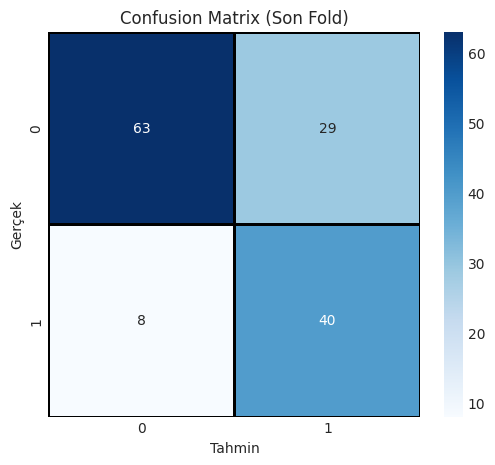

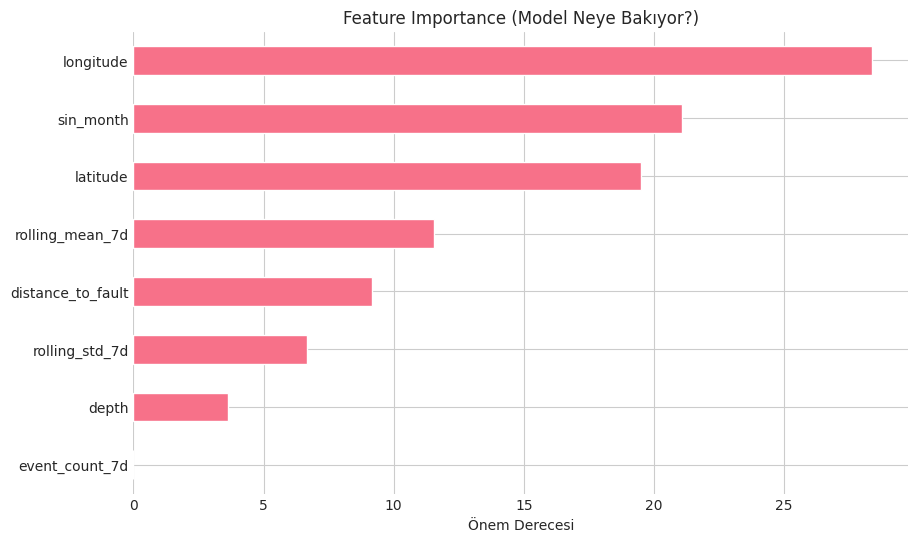

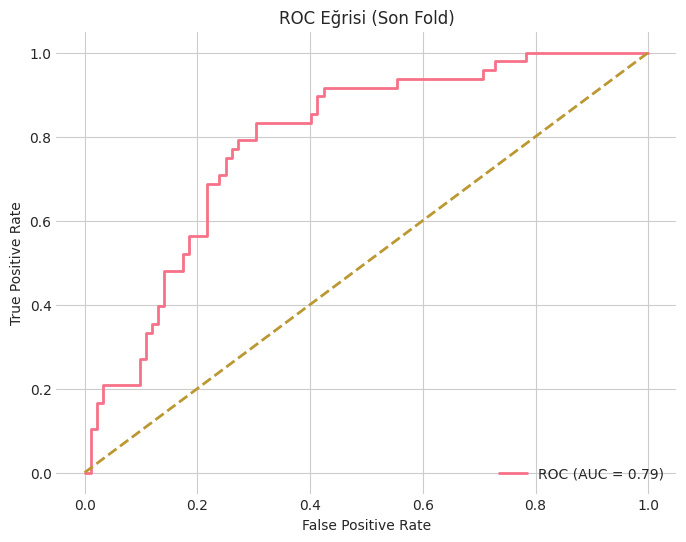

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# A) Confusion Matrix
cm = confusion_matrix(last_y_test, last_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor="black")
plt.title("Confusion Matrix (Son Fold)")
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.show()

# B) Feature Importance
feat_importances = pd.Series(model.get_feature_importance(), index=X.columns)
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).sort_values(ascending=True).plot(kind="barh")
plt.title("Feature Importance (Model Neye Bakıyor?)")
plt.xlabel("Önem Derecesi")
plt.show()

# C) ROC Curve
fpr, tpr, _ = roc_curve(last_y_test, last_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi (Son Fold)")
plt.legend(loc="lower right")
plt.show()


## 12) Uzun Vadeli Deprem Tehlikesi (10 Yıl, M ≥ 6) — İstatistiksel Yaklaşım

Bu bölümde uzun vadeli deprem tehlikesi, geçmiş deprem kayıtlarına dayalı olarak
istatistiksel yöntemle hesaplanır.

Yaklaşım özeti:
- Şehir çevresinde belirli yarıçap içinde (örn. 200 km) **M≥6** deprem sayılır
- Veri kapsadığı süreye göre yıllık oran (λ) hesaplanır
- Poisson varsayımıyla 10 yıl içinde en az 1 büyük deprem olasılığı bulunur

> Not: Bu bölüm "kesin tahmin" değil, **tehlike olasılığı** üretir.


In [ ]:
def compute_long_term_hazard(df_full, city_lat, city_lon,
                             radius_km=200.0, mag_threshold=6.0, years_window=None):
    """
    Basit istatistik:
    - Şehir çevresinde (radius_km) M>=mag_threshold deprem say
    - Katalog süresine göre yıllık oran λ hesapla
    - 10 yılda en az 1 M>=threshold olma olasılığı: P = 1 - exp(-λ*10)
    """
    df_full = df_full.copy()
    df_full = df_full.sort_values("time")

    dists = haversine(city_lat, city_lon,
                      df_full["latitude"].values, df_full["longitude"].values)
    sub = df_full[dists <= radius_km].copy()
    if sub.empty:
        return 0.0

    if years_window is None:
        years = (sub["time"].max() - sub["time"].min()).days / 365.25
    else:
        years = years_window

    if years <= 0:
        return 0.0

    n_big = (sub["mag"] >= mag_threshold).sum()
    lam = n_big / years if n_big > 0 else 0.01 / years  # sıfırsa küçük epsilon

    T = 10.0
    P10 = 1 - math.exp(-lam * T)
    return max(0.0, min(1.0, P10))

print("✓ Uzun vadeli tehlike fonksiyonu hazır.")


✓ Uzun vadeli tehlike fonksiyonu hazır.


## 13) Fay Segmenti Bazlı Risk (Jeolojik Bileşen)

Bu bölümde şehirlerin temsili fay noktalarına olan en yakın mesafesi bulunur.

Amaç:
- Fay hattına yakınlık arttıkça jeolojik risk bileşenini yükseltmek
- Bu bileşeni birleşik risk skoruna bir bileşen olarak eklemek

Not: Kullanılan fay noktaları temsili olup modelleme amacıyla eklenmiştir.


In [ ]:
# Temsili fay noktaları
FAULT_POINTS = [
    (40.9, 29.0), (40.7, 31.0), (40.6, 33.0), (40.5, 36.0),
    (38.0, 36.0), (38.2, 39.0), (38.5, 41.0), (38.6, 43.0),
    (37.5, 27.0), (38.0, 28.0), (38.5, 29.0)
]

def nearest_fault_distance(lat, lon):
    return min([haversine(lat, lon, f[0], f[1]) for f in FAULT_POINTS])

def fault_hazard_score(dist_km):
    """
    Kaba segment risk fonksiyonu:
    - < 30 km -> 1.0 (çok yüksek)
    - 30–80 km -> 0.7 (orta-yüksek)
    - 80–150 km -> 0.4 (orta)
    - >150 km -> 0.1 (düşük)
    """
    if dist_km < 30:
        return 1.0
    elif dist_km < 80:
        return 0.7
    elif dist_km < 150:
        return 0.4
    else:
        return 0.1

print("✓ Fay mesafesi ve segment skoru fonksiyonları hazır.")


✓ Fay mesafesi ve segment skoru fonksiyonları hazır.


## 14) Birleşik Nihai Risk Skoru

Bu bölümde üç bileşen birleştirilir:

1) Kısa vadeli ML riski (CatBoost → 30 gün, M≥4)
2) Uzun vadeli istatistiksel tehlike (Poisson → 10 yıl, M≥6)
3) Fay segment riski (fay hattına yakınlık)

Bu bileşenler ağırlıklandırılarak tek bir final risk skoru üretilir.


In [ ]:
def compute_short_term_ml_risk(city_lat, city_lon, df_main, model, feature_columns, fallback_global=True):
    """
    Şehir çevresindeki son aktiviteye göre 30 gün içinde M>=4 riskini (ML) tahmin eder.
    Not: Bu fonksiyon şehir için son 7 olaydan rolling feature üretir.
    """
    latest_time = df_main["time"].max()
    one_year_ago = latest_time - pd.Timedelta(days=365)

    recent = df_main[df_main["time"] >= one_year_ago].copy()
    dists = haversine(city_lat, city_lon,
                      recent["latitude"].values, recent["longitude"].values)
    recent["dist_to_city"] = dists
    local = recent[recent["dist_to_city"] <= 150.0].copy()

    if len(local) >= 7:
        last_events = local.sort_values("time").tail(7)
    elif fallback_global:
        last_events = df_main.sort_values("time").tail(7)
    else:
        return 0.0

    rolling_mean_7d = last_events["mag"].mean()
    rolling_std_7d = last_events["mag"].std()
    event_count_7d = len(last_events)

    # zaman referansı: en güncel zaman
    t_ref = df_main["time"].max()
    month = t_ref.month
    sin_month = np.sin(2 * np.pi * month / 12)

    dist_fault = nearest_fault_distance(city_lat, city_lon)
    depth_mean = df_main["depth"].mean()

    row = pd.DataFrame([{
        "latitude": city_lat,
        "longitude": city_lon,
        "depth": depth_mean,
        "rolling_mean_7d": rolling_mean_7d,
        "rolling_std_7d": 0.0 if np.isnan(rolling_std_7d) else rolling_std_7d,
        "event_count_7d": event_count_7d,
        "sin_month": sin_month,
        "distance_to_fault": dist_fault
    }])

    proba = model.predict_proba(row[feature_columns])[0][1]
    return max(0.0, min(1.0, float(proba)))

def risk_category(score):
    if score < 0.25:
        return "🟢 DÜŞÜK"
    elif score < 0.50:
        return "🟡 ORTA"
    elif score < 0.75:
        return "🟠 YÜKSEK"
    else:
        return "🔴 ÇOK YÜKSEK"

print("✓ Kısa vadeli ML risk + kategori fonksiyonu hazır.")


✓ Kısa vadeli ML risk + kategori fonksiyonu hazır.


## 15) Şehir Bazlı Risk Tahmini (Canlı Demo)

Bu bölüm notebook’un demo kısmıdır.

Kullanıcı şehir ismi girer ve sistem şu çıktıları üretir:
- Kısa vadeli risk (30 gün, M≥4) → CatBoost olasılığı
- Uzun vadeli tehlike (10 yıl, M≥6) → istatistiksel olasılık
- Fay segment riski → jeolojik skor
- Birleşik nihai risk skoru → tek değer + kategori

Bu bölüm sunumda canlı deneme için tasarlanmıştır.


In [ ]:
def get_city_coords(city_name):
    if city_name in city_coords_dict:
        return city_coords_dict[city_name][0], city_coords_dict[city_name][1]
    return None

def predict_city_risk(city_name):
    coords = get_city_coords(city_name)
    if coords is None:
        print(f"❌ Şehir bulunamadı veya sözlükte yok: {city_name}")
        print("İpucu: city_coords_dict içinde olan bir şehir yaz.")
        return

    city_lat, city_lon = coords

    print(f"\n📍 Şehir: {city_name}")
    print(f"   Konum: {city_lat:.4f}, {city_lon:.4f}")

    # 1) Kısa vadeli ML riski
    short_risk = compute_short_term_ml_risk(city_lat, city_lon, df_main, model, feature_columns)
    short_risk_pct = short_risk * 100

    # 2) Uzun vadeli istatistiksel tehlike
    long_hazard = compute_long_term_hazard(df, city_lat, city_lon, radius_km=200.0, mag_threshold=6.0)
    long_hazard_pct = long_hazard * 100

    # 3) Fay segment riski
    dist_fault = nearest_fault_distance(city_lat, city_lon)
    fault_score = fault_hazard_score(dist_fault)
    fault_score_pct = fault_score * 100

    # 4) Birleşik nihai skor (ağırlıklar)
    final_score = 0.4 * short_risk + 0.3 * long_hazard + 0.3 * fault_score
    final_score_pct = final_score * 100

    print(f"\n📊 Kısa Vadeli Risk (30 gün, M≥4): {short_risk_pct:.2f}%  {risk_category(short_risk)}")
    print(f"📈 Uzun Vadeli Tehlike (10 yıl, M≥6): {long_hazard_pct:.2f}%  {risk_category(long_hazard)}")
    print(f"🗺️ Fay Segment Riski (mesafe {dist_fault:.1f} km): {fault_score_pct:.2f}%  {risk_category(fault_score)}")

    print(f"\n🔎 Bileşik Nihai Risk Skoru: {final_score_pct:.2f}%  {risk_category(final_score)}")

# Canlı demo
if RUN_RISK_APP:
    city = input("\nŞehir ismi girin (örn: İstanbul, İzmir, Van): ").strip()
    predict_city_risk(city)



Şehir ismi girin (örn: İstanbul, İzmir, Van): Konya

📍 Şehir: Konya
   Konum: 37.8713, 32.4841

📊 Kısa Vadeli Risk (30 gün, M≥4): 19.81%  🟢 DÜŞÜK
📈 Uzun Vadeli Tehlike (10 yıl, M≥6): 27.96%  🟡 ORTA
🗺️ Fay Segment Riski (mesafe 306.7 km): 10.00%  🟢 DÜŞÜK

🔎 Bileşik Nihai Risk Skoru: 19.31%  🟢 DÜŞÜK
